In [8]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [9]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [32]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [33]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [34]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [35]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [36]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [37]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 14), X_test: (14150, 14)
y_train: (21225, 1), y_test: (14150, 1)


In [38]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [39]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [40]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [41]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [42]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=14, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [86]:
def implicit_diffusion(self, mean=0.0, std=1.0):
    
    #mean = torch.tensor(mean).to(device)
    #std = torch.tensor(std).to(device)
    
    self = self * std + mean
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = self # temperature profile from previous module output
    dt = 3600 # model time step - fixed
    dx = 1 # model space step - fixed

    # OUTPUT FROM MLP
    d = self #np.array([1e-5] * len(t)) # estimated diffusivity values

    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
    j = len(t)
    y = np.zeros((len(t), len(t)))

    alpha = (dt/dx**2) * d    

    az = alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = -alpha # superdiagonal

    bz[0] = 1
    az[len(az)-2] = 0
    bz[len(bz)-1] = 1
    cz[0] = 0

    # tridiagonal matrix
    for k in range(j-1):
        y[k][k] = bz[k]
        y[k][k+1] = cz[k]
        y[k+1][k] = az[k]

    y[j-1, j-1] = 1

    mn = t * 0.0    
    mn[0] = t[0]
    mn[len(mn)-1] = t[len(t)-1]

    for k in range(1,j-1):
        mn[k] = alpha[k] * t[k-1] + 2 * (1 - alpha[k]) * t[k] + alpha[k] * t[k]

    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    output = np.linalg.solve(y, mn)
    
    proj = output
    
    scaler = StandardScaler()
    scaler.fit(proj.reshape(-1, 1))

    proj = scaler.transform(proj.reshape(-1, 1))
    
    return proj

In [94]:
proj = implicit_diffusion(np.arange(25, 5, -1))

#scaler = StandardScaler()
#scaler.fit(proj.reshape(-1, 1))

#scaler.transform(proj.reshape(-1, 1))

print(proj)

[[ 1.77842326]
 [ 1.4466805 ]
 [ 1.27781142]
 [ 1.10611335]
 [ 0.93446441]
 [ 0.76281462]
 [ 0.59116485]
 [ 0.41951507]
 [ 0.24786529]
 [ 0.07621552]
 [-0.09543426]
 [-0.26708403]
 [-0.43873381]
 [-0.61038358]
 [-0.78203336]
 [-0.95368314]
 [-1.12533363]
 [-1.29702428]
 [-1.47102729]
 [-1.60033091]]


In [121]:
def my_custom_loss(output, target):
    pred = implicit_diffusion(output.detach().numpy())
    #pred = torch.tensor(pred, requires_grad=True).float()
    pred = torch.tensor(pred, grad_fn=<AddmmBackward0>).float() 
    pred.retain_grad()
    #print( pred.grad)
    #pred.grad.data.copy_(output.grad.data)
    #pred = torch.from_numpy(pred)
    
    print(pred)
    print(target)
    loss = (pred - target)
    print(loss)
    return loss

SyntaxError: invalid syntax (2692081903.py, line 4)

In [122]:
tensor([1., 1., 1., 1., 1.], grad_fn=<CloneBackward0>)

SyntaxError: invalid syntax (1481997625.py, line 1)

In [120]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        #print(model(x))
        proj = model(x)
        
        # torch.set_printoptions(profile="full")
        print(proj) 
        
        # pred = implicit_diffusion(proj.detach().numpy())
        # pred = model(x)
        # pred = torch.from_numpy(pred)
        # print(pred)
        # print(y)
        
        # pred.grad.data.copy_(proj.grad.data)
        
        # proj[0:30,0] = pred
        
        # print(proj)

        # loss = criterion(pred, y)
        loss = my_custom_loss(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            #proj = model(x)
            #pred = implicit_diffusion(proj.detach().numpy())
            #pred = torch.from_numpy(pred)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[ 1.4604e+00],
        [-6.3304e-01],
        [ 3.6501e-01],
        [-1.2058e+00],
        [ 1.6849e+00],
        [-3.2717e-01],
        [-1.3964e-01],
        [ 1.4439e+00],
        [-2.1284e-02],
        [ 3.3486e-01],
        [ 9.1337e-01],
        [-1.2800e+00],
        [-4.2363e-01],
        [ 2.1595e-01],
        [-7.7214e-01],
        [-7.1138e-01],
        [-1.0435e+00],
        [-9.6928e-01],
        [-1.1086e+00],
        [-1.8777e-01],
        [ 1.8199e-01],
        [ 4.5270e-01],
        [ 1.3016e+00],
        [-7.1354e-01],
        [ 9.3957e-01],
        [-6.1601e-01],
        [-3.5652e-01],
        [ 1.8460e+00],
        [ 1.0979e+00],
        [-1.2885e+00],
        [-1.1179e+00],
        [-1.0900e+00],
        [-9.8784e-01],
        [ 6.0133e-01],
        [-5.8357e-02],
        [-5.2429e-01],
        [-2.2694e-01],
        [-1.0044e+00],
        [ 4.4016e-01],
        [-1.2125e+00],
        [-8.4534e-01],
        [ 3.3412e-01],
        [-6.3569e-01],
        [-6

AttributeError: 'NoneType' object has no attribute 'copy_'

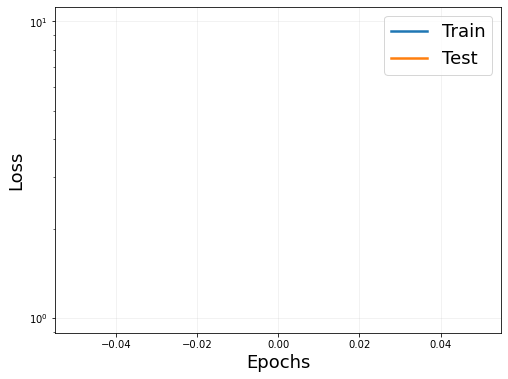

In [102]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [23]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [24]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Diffusivity: 9.859477536592607e-06
Test Rmse of Temp: 0.7826148693716032
L2 Error of Diffusivity: 0.4382787878287092
L2 Error  of Temp: 0.053899259632144064


In [25]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Diffusivity: 1.407105732980103e-06
Train Rmse of Temp: 0.06460328518966645
L2 Error of Diffusivity: 0.06055042984845283
L2 Error  of Temp: 0.005046837794778314


# Saving Model

In [26]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [27]:
output_mean

array([2.07829505e-05, 1.13460421e+01])